In [2]:
import numpy as np
import pandas as pd
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#Run the below piece of code for the first time
#nltk.download('stopwords')

In [3]:
dialogs_data = pd.read_csv("dialog_lines.csv",encoding = "UTF8")
dialogs_data.head()

,racist/not_racist,dialog_line
0,not_racist,\n\n\n \n\n\n\n CONTINUED\n\...
1,not_racist,\n\n\n \n\n\n\n CONTINUED\n\...
2,not_racist,NIGHT\n\n\n\n\n \n\n\n\n \n...
3,not_racist,\n\n\n\n \n\n\n\n \n\n\n\n ...
4,not_racist,Im going inside\n\n\n \n\n\n\n ...


In [4]:
dialogs_data.groupby('racist/not_racist').describe()


dialog_line                                     
                        count unique                      top freq
racist/not_racist                                                 
not_racist              38014  32277  \n\n                     304
racist                   1377   1371          BEMBRY \n\n\t\t    4

In [5]:
nrd = dialogs_data[dialogs_data['racist/not_racist'] == 'not_racist'].sample(1371)


In [6]:
#dialogs_data.groupby('racist/not_racist').describe()

nrd = dialogs_data[dialogs_data['racist/not_racist'] == 'not_racist'].sample(1371)
rd = dialogs_data[dialogs_data['racist/not_racist'] == 'racist']

dialogs_data = pd.concat([nrd, rd])
dialogs_data.groupby('racist/not_racist').describe()


dialog_line                                     
                        count unique                      top freq
racist/not_racist                                                 
not_racist               1371   1279  \n\n                      17
racist                   1377   1371          BEMBRY \n\n\t\t    4

In [7]:
dialogs_data_copy = dialogs_data['dialog_line'].copy()


In [8]:
def text_preprocess(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(text)

In [9]:
dialogs_data_copy = dialogs_data_copy.apply(text_preprocess)

In [10]:
dialogs_data_copy

14904                                               JEREMY
35340                                            crown ALI
36754                                    world cares April
31623    DEACON CONTD ever think getting film Way uncom...
31270                                   Thats problem weve
                               ...                        
39313    remove lids finelycrafted false bottoms reveal...
39315    minister steps welcomes congregation includes ...
39316    laundry truck comes past guard gate leaves bas...
39337    Several black white undercover cars approach s...
39356    Frank moves gallery Richie sees full gangsters...
Name: dialog_line, Length: 2748, dtype: object

In [11]:
vectorizer = TfidfVectorizer()

In [12]:
dialogs_mat = vectorizer.fit_transform(dialogs_data_copy)
dialogs_mat

<2748x8322 sparse matrix of type '<class 'numpy.float64'>'
	with 33820 stored elements in Compressed Sparse Row format>

In [13]:
dialogs_train, dialogs_test, r_nr_train, r_nr_test = train_test_split(dialogs_mat, 
                                                        dialogs_data['racist/not_racist'], test_size=0.3, random_state=20)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
#solver='liblinear', penalty='l1'
racist_model = LogisticRegression()
racist_model.fit(dialogs_train, r_nr_train)
pred = racist_model.predict(dialogs_test)
accuracy_score(r_nr_test,pred)
print("Accuracy:",metrics.accuracy_score(r_nr_test,pred))


Accuracy: 0.8775757575757576


# Bootstrapping

In [15]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

In [16]:
accuracy = []
n_iterations = 1000
for i in range(n_iterations):
    X_bs, y_bs = resample(dialogs_train, r_nr_train, replace=True)
    # make predictions
    y_hat = racist_model.predict(X_bs)
    # evaluate model
    score = accuracy_score(y_bs, y_hat)
    accuracy.append(score)

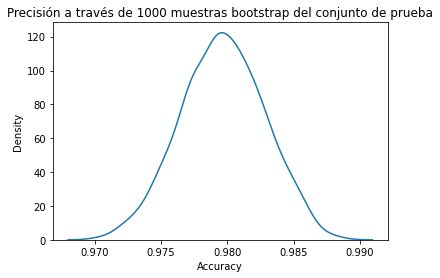

In [23]:
import seaborn as sns
# plot distribution of accuracy
sns.kdeplot(accuracy)
plt.title("Precisión a través de 1000 muestras bootstrap del conjunto de prueba")
plt.xlabel("Accuracy")
plt.show()


## Analizando el modelo

In [18]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [19]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(r_nr_test, pred)
cnf_matrix

array([[382,  33],
       [ 68, 342]])

In [20]:

r_nr_test = np.array(list(map(lambda s: 0 if s == "not_racist" else 1, r_nr_test)))

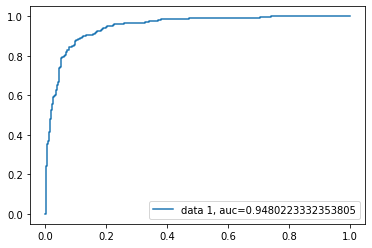

In [21]:
y_pred_proba = racist_model.predict_proba(dialogs_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(r_nr_test,  y_pred_proba)
auc = metrics.roc_auc_score(r_nr_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Text(0.5, 257.44, 'Predicted label')

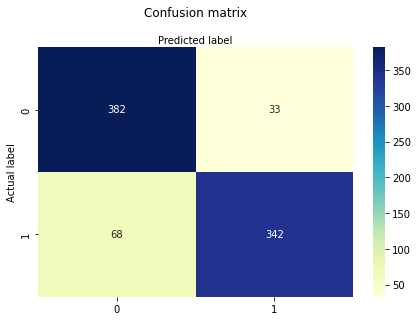

In [22]:
class_names=["not_racist","racist"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')